
 # of time steps =  1428
 # cells along x =  1000




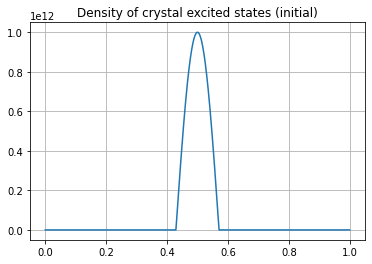

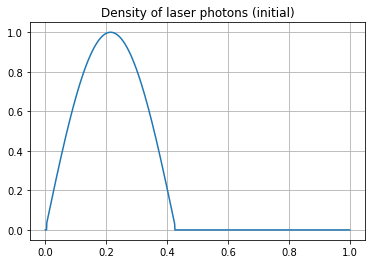

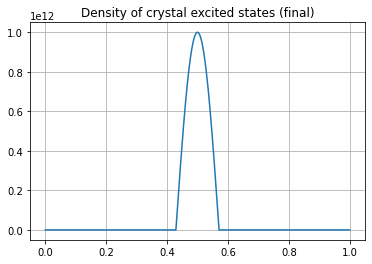

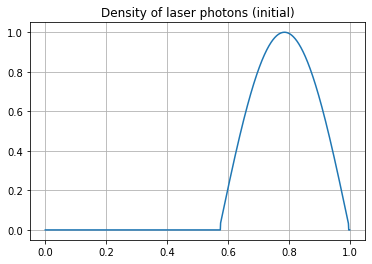

In [19]:
'''
File:  fn_simp_04.py

This test shows a static distribution of excited states in a crystal,
with an overlapping static distribution of photons.

The only dynamical equation is that of the excited states in the crystal.
'''
from dolfin import *
import matplotlib.pyplot as plt

# Specify the BCs
def on_left(x, on_boundary):
    return (on_boundary and near(x[0], 0.))

def on_right(x, on_boundary):
    return (on_boundary and near (x[0], 1.))

V_x = 0.5708215297450425
n_ds = 1000
ds = 1./n_ds
lp_density = 1.
lp_width = 0.42917847025495753
c_density = 1.e12
c_width = 0.141643059490085
c_sigma = 1.e-21

# create a 1D mesh on the interval [0,1]
mesh = UnitIntervalMesh(n_ds)
V = FunctionSpace(mesh, "CG", 3)
v = TestFunction(V)

u = Function(V)
uprev = Function(V)
    
# instantiate the corresponding FEniCS objects for Dirichlet BCs
bc_left = DirichletBC(V, Constant(0), on_left)
bc_right = DirichletBC(V, Constant(0), on_right)
bc = [bc_left, bc_right]

# initial conditions for number density of excited states
u0 = Expression(('x[0]>=lp_width && x[0]<=(lp_width+c_width) ? \
                c_density*sin(pi*(x[0]-lp_width)/c_width) : 0.'), \
                degree=3, lp_width=0.2, c_width=0.6, c_density=1., ds=0.01)
u0.c_width = c_width
u0.lp_width = lp_width
u0.c_density = c_density
u0.ds = ds
    
# project the above expression onto the solution vector
u = interpolate(u0, V)
uprev.assign(u)

# define the externally imposed laser pulse
ulaser = Expression(('(x[0]-V_x*t)>4.*ds && (x[0]-V_x*t)<(lp_width-4.*ds) ? \
                lp_density*sin(pi*(x[0]-V_x*t)/lp_width) : 0.'), \
                degree=3, lp_width=0.2, V_x=0.6, lp_density=1., t=0., ds=0.01)
ulaser.lp_width = lp_width
ulaser.lp_density = lp_density
ulaser.V_x = V_x
ulaser.ds = ds

time = 2.
dt = 0.8 * ds / V_x
n_steps = int(1 + time / dt)

print('')
print(' # of time steps = ', n_steps)
print(' # cells along x = ', n_ds)
print('')
print('')

DT = Constant(dt)
VX = Constant(V_x)
SIGMA = Constant(c_sigma)

# inital plot of excited states and laser pulse envelope
uplot = project(u, V)
plot(uplot, title=('Density of crystal excited states (initial)'))
plt.grid(True)
plt.show()
plt.close()

uplot = project(ulaser, V)
plot(uplot, title=('Density of laser photons (initial)'))
plt.grid(True)
plt.show()
plt.close()

# try to get some numerical diagnostics
set_log_level(LogLevel.INFO)

t=0.5*dt
for i_loop in range(0, n_steps):
    ulaser.t = t
    t += 0.5*dt
    
    F = ( (u - uprev) * v / DT \
         + SIGMA * u * ulaser * v
        ) * dx
    
#    Jacobian = derivative(F, u)
#    solve(F==0, u, bc, J=Jacobian)
    solve(F==0, u, bc)
    uprev.assign(u)
    
#    print('i_loop = ', i_loop)
#    if i_loop > 200:
#        break

# final plot of excited states and laser pulse envelope
uplot = project(u, V)
plot(uplot, title=('Density of crystal excited states (final)'))
plt.grid(True)
plt.show()
plt.close()

uplot = project(ulaser, V)
plot(uplot, title=('Density of laser photons (initial)'))
plt.grid(True)
plt.show()
plt.close()